## Examples

#### Basic ensemble learning

Here we build from scratch a model made using ensemble learning. We fit three different classifiers on the data, then the ensemble model outputs the majority vote as label, given the input data. This way of voting is also called *hard voting*.  

In [1]:
# generate dataset: MoonDataSet
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

data = make_moons(1000, random_state=67)
X = data[0]
y = data[1]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.2, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_cl = SVC()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_cl)],
    voting="hard"
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_cl, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.87625
RandomForestClassifier 0.9925
SVC 1.0
VotingClassifier 0.99375


#### Bagging and Pasting

The following code performs bagging using decision trees as weak learners. This is NOT a random forest, because making one of them requires sampling from the possible features at each split for each tree.  

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), # weak learner model: Decision Tree
    n_estimators=500, # number of weak learners 
    max_samples=100, # The number of samples to draw from the training set to train each weak learner. By default it is equal to the test dataset size
    bootstrap=True, # create bootstrap samples (aka: bagging)
    n_jobs=2
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.98625


#### Out-of-bag evaluation

For performing out of bag evaluation (something like cross validation error for bagged models) you just have set the parameter of the *BaggingClassifier*, named *oob_score*, to *True*. 

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), # weak learner model: Decision Tree
    n_estimators=500, # number of weak learners
    bootstrap=True, # create bootstrap samples (aka: bagging)
    n_jobs=2,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.99

#### Random Forests 

In [6]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.9925


The random forest class has also the attribute *feature_importance*. This means that at every feature an importance value is associate. The score is given by considering the average Gini impurity diminishment given by a feature, when it is chosen for perofrming a split during the training of weak learners. 

In [7]:
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)


sepal length (cm) 0.08988388392532216
sepal width (cm) 0.02437890184416353
petal length (cm) 0.4335271292052299
petal width (cm) 0.4522100850252844


It seems like the most important features are:

petal length (cm) 0.45825310463423896

petal width (cm) 0.42142698193259726

#### AdaBoost

Implementing an AdaBoost classifier. This ensemble algorithm trains the weak learners sequentially, over a modified datasets, where each instance is weighted based upon how hard the past models found that instance to correctly classify. The more difficult, the more weight the instance has. The weight also corresponds to how much importance is given from the model to a specific training instance. The more weight, the more attention is given.

In [8]:
from sklearn.ensemble   import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), # we use decision trees as weak learners, imposing the depth equal to 1
    n_estimators=200, # number of weak learners to train
    algorithm="SAMME", # training algorithm
    learning_rate=0.5 # the alpha
)

ada_clf.fit(X_train, y_train) 

y_pred_rf = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

c:\Users\bianc\Documents\VSC_code\HandsOnMachineLearning\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


1.0


#### Gradient Boosting (with decision trees)

In sklearn the *GradientBoostinRegressor* exists. This is an implementation of a boosting algorithm opimized for using decision trees as weak learners. Boosting trains the weak learners sequentially, using as label the residual errors the previous model made. 

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train, y_train)

y_pred_rf = gbrt.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.9725


The following code stops the training and creation of sequential models when the validation error does not improve for five iterations in a row. Infact knowing a priori how many weak learnenrs are need for the task is pretty difficult. Setting an early stop confition like this one can help us out dynamically.

In [14]:
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping 


## Exercises

1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there an chance that you can combine these models to get better results? If so, how? If not, why?

Ensemble learning works by leveraing the CLT. Infact that theorem says that the average is asimptotically distributed like a Gaussian, whose variance is equal to the variance of the base random variable divided by the number of instances considered to compute the average. This is valid if the random variable upon whose the average is taken are iid. So for example, by takong the average result of the five models chances are that, if these answers are non-collinear, that the ensemble model will perform better because of this variance reductive effect. 

2. What is the difference between hard and soft voting classifiers?

The difference stands in how the model responses are aggregated to generate the overall model repsponse. In hard voting a simple aggregating function is used (the average for regression, the mode class for classification). In soft voting anothe model is trained on a part of training set to aggregate the responses of the first models, creating a layered structure (infact this approach is also called stacking).

3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers?

Yes it is. Infact the ensemble models are trained in parallel on a boostrap sample created from the startin training set. Infact this is a big advantage of the boosting approach, it scales very well.

4. What is the benefit ofout-of-bag evaluation?

The benefit of oob evaluation is that, when computed for bagged models, it is an approximation of the validation error of the model. Hence, cross validating the model can be avoided, generating a time advantage. Infact, just as cross validation error is an aprroximation of the test error, also the oob evaluation is. 

5. What make extra trees more random the regular random forests? How can this extra randomness help? Are extra tree slower or faster than regular Random Forests?

Extra tree are different from RF, since they add more randomness to the overall algorithm. Infact at every split of every ensemble tree, the threshold t is chosen randomly. This causes the ensemle models to be very different on average from each other, improving their mutual indipendence This results in creating a more iid ensemble, enhancing even more the CLT variance reduction effect that is the goal of ensemble learning. Also the fact that t is chosen randomly reduces the computational effort required to train extra tree, wrt the time needed to train a random forests, where at each split a cost function is optimized wrt a pair of feature-threshold ($X_j,t_j$)

6. If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak and how? 

I would place increase te learning rate value used in the computation of the model weight ($\eta$). I would consider inrasing the number of trained models in the ensemble. I would try to increase the complexity of the base estimator, for example if they are trees I would increase their maximum depth. 

7. If your gradient boosting enemble overfits the training set, should you increase or decrease the learning rate? 

In this case the learning rate should be decreased. Infact the higher it is the faster the ensemble will correct the overall residual error. Making these corrections too fast can bring to overfitting the data. If this happens an idea could be decreasing the learning rate value. Anothe thing that could be done is using: early stopping, considering less complicate base models. 

8. On the MNIST dataset find hwo much better an ensemble method performs than base models

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# data
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
from sklearn.model_selection import train_test_split
# 63000 instaces for training, 7000 for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, train_size = 0.9, random_state=42) 

# 50400 instances for training, 12600 for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42) 

In [6]:
# training various classifiers 
# Random forest classifier, Extra-Trees classifier, SVM classifier, Logistic Regression
 
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC # SVC with linear kernel, optimized for scaling better with large samples

# model creation
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42, criterion= "gini", n_jobs=-1)
svc = LinearSVC(max_iter=100, tol = 20 , random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, criterion="gini", n_jobs=-1)
lr = OneVsOneClassifier(LogisticRegression(), n_jobs=-1)

In [7]:
estimators = [rnd_forest, svc, etc, lr]

for estimator in estimators:
    print("training the: ", estimator)
    estimator.fit(X_test, y_test)

training the:  RandomForestClassifier(n_jobs=-1, random_state=42)
training the:  LinearSVC(max_iter=100, random_state=42, tol=20)
training the:  ExtraTreesClassifier(n_jobs=-1)
training the:  OneVsOneClassifier(estimator=LogisticRegression(), n_jobs=-1)


In [8]:
from sklearn.metrics import accuracy_score
# assessing model accuracy on the test set 

y_val_pred_rf = rnd_forest.predict(X_val)
y_val_pred_svc = svc.predict(X_val)
y_val_pred_etc = etc.predict(X_val)
y_val_pred_lr = lr.predict(X_val)

acc_rf = accuracy_score(y_val, y_val_pred_rf)
acc_svc = accuracy_score(y_val, y_val_pred_svc)
acc_etc = accuracy_score(y_val, y_val_pred_etc)
acc_lr = accuracy_score(y_val, y_val_pred_lr)

print(f"Random Forest validation accuracy: {acc_rf}")
print(f"Support Vector Classifier validation accuracy: {acc_svc}")
print(f"Extra-Tress classifier validation accuracy: {acc_etc}")
print(f"OvO logistic regression validation accuracy: {acc_lr}")

Random Forest validation accuracy: 0.9463492063492064
Support Vector Classifier validation accuracy: 0.09944444444444445
Extra-Tress classifier validation accuracy: 0.9511111111111111
OvO logistic regression validation accuracy: 0.9111111111111111


In [13]:
from sklearn.ensemble import VotingClassifier

# creating the ensemble method with hard voting. Infact not all models can output a probability
ensemble_model = VotingClassifier(estimators = [("Random Forest", rnd_forest ), ("svc", svc), ("etc", etc), ("Logistic Regression", lr)], voting = "hard")
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('svc',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('etc', ExtraTreesClassifier(n_jobs=-1)),
                             ('Logistic Regression',
                              OneVsOneClassifier(estimator=LogisticRegression(),
                                                 n_jobs=-1))])

The ensemble method has the best accuracy score overall.

In [ ]:
# assessing performance of the ensemble method

y_val_predict_ensemble = ensemble_model.predict(X_val)
acc_ensemble_model = accuracy_score(y_val, y_val_predict_ensemble)
print(f"ensemble classifier validation accuracy: {acc_ensemble_model}")

# with svm, Random Forest, exc: 96.66 % accuracy
# with all models: 97 % accuracy

ensemble classifier validation accuracy: 0.97


Looking at the accuracy score of each model it seems that the LVC doesn't work well. Let's try removing it from the ensemble model and check if there is an improvement in performance.

In [21]:
ensemble_model.estimators_

[RandomForestClassifier(n_jobs=-1, random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 ExtraTreesClassifier(n_jobs=-1),
 OneVsOneClassifier(estimator=LogisticRegression(), n_jobs=-1)]

In [22]:
# remove the svc
del ensemble_model.estimators_[1]
ensemble_model.estimators_

[RandomForestClassifier(n_jobs=-1, random_state=42),
 ExtraTreesClassifier(n_jobs=-1),
 OneVsOneClassifier(estimator=LogisticRegression(), n_jobs=-1)]

In [ ]:
# the .score ethod returns the overall model accuracy wrt to the input data
ensemble_model.score(X_val, y_val)

0.9726984126984127

By removing the SVC from the ensemble model we achieved a final 97.27% accuracy score on the test set. That is a little improvement from before. A thing that could be done is fine-tunng every model using a GridSearch or a random serach. 

Here's an overall example of the model working

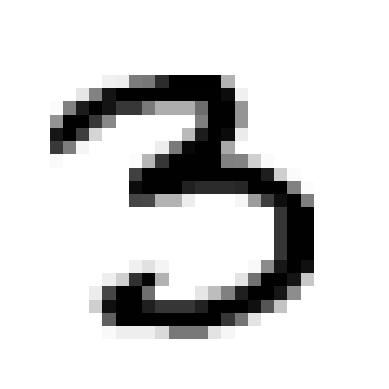

In [24]:
# example
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
some_digit = X_test.iloc[98] # changing the index here shows a different number
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()


In [25]:
predictions = ensemble_model.predict(X_test)
print(predictions[98]) # use the same index here and watch what the model sees

3


9. Instead of using a hard voting method for the ensemble model, implement a stacked model

In [27]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC # SVC with linear kernel, optimized for scaling better with large samples

# first layer models:
# Random forest classifier, Extra-Trees classifier, SVM classifier, Logistic Regression
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42, criterion= "gini", n_jobs=-1)
svc = LinearSVC(max_iter=100, tol = 20 , random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, criterion="gini", n_jobs=-1)
lr = OneVsOneClassifier(LogisticRegression(), n_jobs=-1)

# second layer model:
# Random Forest
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [28]:
# training the first layer on the training set (X_train, y_train)

estimators = [rnd_forest, svc, etc, lr]

for estimator in estimators:
    print("training the: ", estimator)
    estimator.fit(X_test, y_test)

training the:  RandomForestClassifier(n_jobs=-1, random_state=42)
training the:  LinearSVC(max_iter=100, random_state=42, tol=20)
training the:  ExtraTreesClassifier(n_jobs=-1)
training the:  OneVsOneClassifier(estimator=LogisticRegression(), n_jobs=-1)


In [29]:
import numpy as np

X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [30]:
X_val_predictions

array([[3., 0., 3., 3.],
       [5., 0., 5., 5.],
       [4., 0., 4., 4.],
       ...,
       [8., 0., 8., 8.],
       [0., 0., 0., 0.],
       [6., 0., 6., 6.]], shape=(12600, 4), dtype=float32)

Now let's train the Decision Tree Classifier on the y_val data, taking as X the X_val_prediction values, which are the output predictions of the first layer models.

In [32]:
rnd_forest_blender.fit(X_val_predictions, y_val)
rnd_forest_blender.oob_score_

0.9537301587301588

In this case the hard voting works better than using a Random Forest as blender model. A thing that could be done is checking whether a different odel would perform better than a random forest or not, for this particular task.